In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import random
import numpy as np

import ranger21

In [2]:
my_seed = 2 ** 27 - 15
random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed);

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
data = datasets.ImageFolder(
    '12. Animal Image Dataset(DOG, CAT and PANDA)/animals',
    transform)

In [5]:
transformers = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
    transforms.ColorJitter(0.5, 0.3),
)
scripted_transforms = torch.jit.script(transformers)

In [6]:
train_data, val_data = torch.utils.data.random_split(data, [0.9, 0.1])

In [7]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.Mish(),
                        nn.Dropout(0.3))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.dropout = nn.Dropout(0.3)
        self.downsample = downsample
        self.mish = nn.Mish()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.mish(out)
        out = self.dropout(out)

        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.Mish())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.layer4  = self._make_layer(block, 1024, layers[4], stride = 2)
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc1 = nn.Linear(9216, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.mish = nn.Mish()
        self.dropout = nn.Dropout(0.3)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        if self.training:
            x = scripted_transforms(x)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.mish(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [13]:
num_classes = 3
num_epochs = 200
learning_rate = 5e-4

model = ResNet(ResidualBlock, [3, 4, 6, 4, 3], 3).to(device)

total_step = len(train_dataloader)

criterion = nn.CrossEntropyLoss()
optimizer = ranger21.Ranger21(model.parameters(), lr=learning_rate, num_epochs=num_epochs, num_batches_per_epoch=total_step)

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.0005

Important - num_epochs of training = ** 200 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 12240 of 17000
warm down will decay until 3e-05 lr


In [12]:
checkpoint = torch.load('saved_models/95.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']
acc = checkpoint['val_acc']

In [14]:
acc = 0
start_epoch = 0

In [15]:
# Эта ячейка запускалась несколько раз и до этого здесь были 190 эпох, 
# которые не сохранились

train_acc, test_acc, best_acc = 0, 0, 0
best_acc = acc

for epoch in range(start_epoch, num_epochs):
    correct = 0
    total = 0
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = correct / total * 100
    print ('Epoch [{}/{}]\n\tLoss: {:.5f}     TrainAcc: {:.3f} %'
                   .format(epoch+1, num_epochs, loss.item(), 100 * correct / total), end='     ')

    # Validation
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_acc = correct / total * 100
        print('ValAcc: {:.3f} %'.format(100 * correct / total))

    if epoch > 20 and val_acc > best_acc:
        best_acc = val_acc
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            },
            f'./saved_models/best.pt',
        )
    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            },
            f'./saved_models/last.pt',
        )

params size saved
total param groups = 1
total params in groups = 184
Epoch [190/200]
	Loss: 0.00001     TrainAcc: 96.778 %     ValAcc: 94.667 %
Epoch [191/200]
	Loss: 0.00001     TrainAcc: 96.926 %     ValAcc: 95.000 %
Epoch [192/200]
	Loss: 0.00004     TrainAcc: 96.926 %     ValAcc: 95.000 %
Epoch [193/200]
	Loss: 0.00225     TrainAcc: 96.741 %     ValAcc: 93.667 %
Epoch [194/200]
	Loss: 0.00001     TrainAcc: 97.333 %     ValAcc: 94.000 %
Epoch [195/200]
	Loss: 0.00116     TrainAcc: 97.407 %     ValAcc: 95.000 %
Epoch [196/200]
	Loss: 0.42029     TrainAcc: 97.296 %     ValAcc: 94.667 %
Epoch [197/200]
	Loss: 0.03648     TrainAcc: 97.148 %     ValAcc: 94.000 %
Epoch [198/200]
	Loss: 0.00001     TrainAcc: 97.000 %     ValAcc: 95.000 %
Epoch [199/200]
	Loss: 0.00000     TrainAcc: 96.704 %     ValAcc: 95.000 %
Epoch [200/200]
	Loss: 0.01097     TrainAcc: 97.074 %     ValAcc: 94.667 %


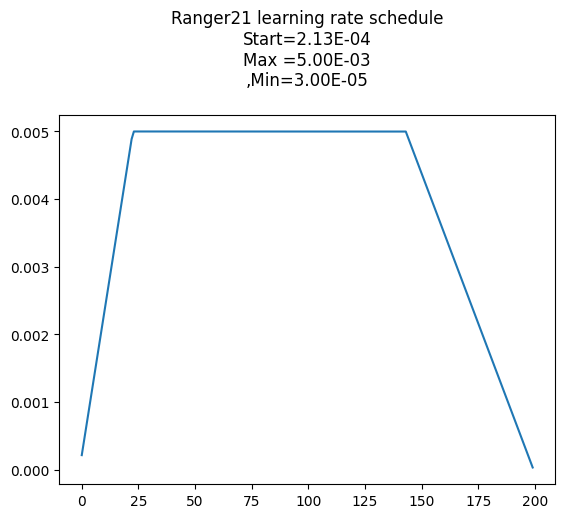

In [ ]:
optimizer.show_schedule()